# Entity Resolution project @ Wavestone
## Entity Matching

> *Datasets information from [here](https://data.dws.informatik.uni-mannheim.de/benchmarkmatchingtasks/index.html)*

> **Tristan PERROT**


## Import libraries

In [57]:
import os

while 'model' not in os.listdir():
    os.chdir('..')

In [77]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import (accuracy_score, auc, confusion_matrix, f1_score,
                             precision_score, recall_score, roc_auc_score,
                             roc_curve)

import src.bert.result_berts as result_berts
import src.blocking.result_blocking as result_blocking
import src.cross_encoder.result_sberts as result_sberts
import src.import_data as import_data
import src.zero_shot.result_zero_shot as result_zero_shot
from model.Blocking import get_blocking_metrics, merge_true_matches
from model.utils import load_data

In [59]:
print('Available models for Zero-Shot:')
print(result_zero_shot.MODELS)
print()
print('Available models for BERTs:')
print(result_berts.MODELS)
print()
print('Available models for SBERTs:')
print(result_sberts.MODELS)
print()
print('Available models for Blocking:')
print(result_blocking.MODELS)
print()
print('Available datasets:')
print(result_zero_shot.DATA_NAMES)

Available models for Zero-Shot:
['all-mpnet-base-v2', 'sentence-transformers/multi-qa-mpnet-base-dot-v1']

Available models for BERTs:
['roberta-base', 'distilroberta-base', 'bert-base-uncased']

Available models for SBERTs:
['cross-encoder/stsb-roberta-base', 'cross-encoder/stsb-distilroberta-base', 'cross-encoder/ms-marco-MiniLM-L-12-v2', 'cross-encoder/stsb-roberta-large']

Available models for Blocking:
['sentence-transformers/allenai-specter', 'all-distilroberta-v1', 'all-mpnet-base-v2', 'multi-qa-mpnet-base-dot-v1']

Available datasets:
['fodors-zagats', 'amazon-google', 'abt-buy']


In [60]:
THRESHOLD = 0.65

## Load results

### ZERO-SHOT

In [61]:
preds = {}
results_dict_zshot = {}
for data_name in result_zero_shot.DATA_NAMES:
    results_dict_zshot[data_name] = {}
    table_a_serialized, table_b_serialized, X_train_ids, y_train, X_valid_ids, y_valid, X_test_ids, y_test = load_data(os.path.join(import_data.DATA_FOLDER, data_name))
    for model_name in result_zero_shot.MODELS:
        results_dict_zshot[data_name][model_name] = {}
        for order_cols in result_zero_shot.LOAD_OPTIONS['order_cols']:
            results_dict_zshot[data_name][model_name][order_cols] = {}
            for remove_col_names in result_zero_shot.LOAD_OPTIONS['remove_col_names']:
                dir_name = f'{data_name}-zshot/{model_name}-order_cols_{order_cols}-remove_col_names_{remove_col_names}'
                logits = pd.read_csv(os.path.join('results', dir_name, 'logits.csv'), names=['idA', 'idB', 'pred'])
                with open(os.path.join('results', dir_name, 'train_time.txt'), 'r') as file:
                    train_time = float(file.read().strip())
                results_dict_zshot[data_name][model_name][order_cols][remove_col_names] = {}
                results_dict_zshot[data_name][model_name][order_cols][remove_col_names]['precision'] = precision_score(y_test, logits['pred'].values > THRESHOLD)
                results_dict_zshot[data_name][model_name][order_cols][remove_col_names]['recall'] = recall_score(y_test, logits['pred'].values > THRESHOLD)
                results_dict_zshot[data_name][model_name][order_cols][remove_col_names]['f1'] = f1_score(y_test, logits['pred'].values > THRESHOLD)
                results_dict_zshot[data_name][model_name][order_cols][remove_col_names]['roc_auc'] = roc_auc_score(y_test, logits['pred'].values)
                results_dict_zshot[data_name][model_name][order_cols][remove_col_names]['accuracy'] = accuracy_score(y_test, logits['pred'].values > THRESHOLD)
                results_dict_zshot[data_name][model_name][order_cols][remove_col_names]['confusion_matrix'] = confusion_matrix(y_test, logits['pred'].values > THRESHOLD)
                fpr, tpr, _ = roc_curve(y_test, logits['pred'].values)
                results_dict_zshot[data_name][model_name][order_cols][remove_col_names]['roc_curve'] = (fpr, tpr, auc(fpr, tpr))
                results_dict_zshot[data_name][model_name][order_cols][remove_col_names]['logits'] = logits
                results_dict_zshot[data_name][model_name][order_cols][remove_col_names]['train_time'] = train_time

### FEW-SHOT

### CROSS-ENCODER

In [62]:
preds = {}
results_dict_cross = {}
for data_name in result_sberts.DATA_NAMES:
    results_dict_cross[data_name] = {}
    table_a_serialized, table_b_serialized, X_train_ids, y_train, X_valid_ids, y_valid, X_test_ids, y_test = load_data(os.path.join(import_data.DATA_FOLDER, data_name))
    for model_name in result_sberts.MODELS:
        if model_name == 'cross-encoder/stsb-roberta-large': continue
        results_dict_cross[data_name][model_name] = {}
        for order_cols in result_sberts.LOAD_OPTIONS['order_cols']:
            results_dict_cross[data_name][model_name][order_cols] = {}
            for remove_col_names in result_sberts.LOAD_OPTIONS['remove_col_names']:
                dir_name = f'{data_name}-{model_name}-order_cols_{order_cols}-remove_col_names_{remove_col_names}'
                logits = pd.read_csv(os.path.join('results', dir_name, 'logits.csv'), names=['idA', 'idB', 'pred'])
                with open(os.path.join('results', dir_name, 'train_time.txt'), 'r') as file:
                    train_time = float(file.read().strip())
                results_dict_cross[data_name][model_name][order_cols][remove_col_names] = {}
                results_dict_cross[data_name][model_name][order_cols][remove_col_names]['precision'] = precision_score(y_test, logits['pred'].values > result_sberts.threshold)
                results_dict_cross[data_name][model_name][order_cols][remove_col_names]['recall'] = recall_score(y_test, logits['pred'].values > result_sberts.threshold)
                results_dict_cross[data_name][model_name][order_cols][remove_col_names]['f1'] = f1_score(y_test, logits['pred'].values > result_sberts.threshold)
                results_dict_cross[data_name][model_name][order_cols][remove_col_names]['roc_auc'] = roc_auc_score(y_test, logits['pred'].values)
                results_dict_cross[data_name][model_name][order_cols][remove_col_names]['accuracy'] = accuracy_score(y_test, logits['pred'].values > result_sberts.threshold)
                results_dict_cross[data_name][model_name][order_cols][remove_col_names]['confusion_matrix'] = confusion_matrix(y_test, logits['pred'].values > result_sberts.threshold)
                fpr, tpr, _ = roc_curve(y_test, logits['pred'].values)
                results_dict_cross[data_name][model_name][order_cols][remove_col_names]['roc_curve'] = (fpr, tpr, auc(fpr, tpr))
                results_dict_cross[data_name][model_name][order_cols][remove_col_names]['logits'] = logits
                results_dict_cross[data_name][model_name][order_cols][remove_col_names]['train_time'] = train_time

### BERT

In [63]:
preds = {}
results_dict_bert = {}
for data_name in result_berts.DATA_NAMES:
    results_dict_bert[data_name] = {}
    table_a_serialized, table_b_serialized, X_train_ids, y_train, X_valid_ids, y_valid, X_test_ids, y_test = load_data(os.path.join(import_data.DATA_FOLDER, data_name))
    for model_name in result_berts.MODELS:
        results_dict_bert[data_name][model_name] = {}
        for order_cols in result_berts.LOAD_OPTIONS['order_cols']:
            results_dict_bert[data_name][model_name][order_cols] = {}
            for remove_col_names in result_berts.LOAD_OPTIONS['remove_col_names']:
                dir_name = f'{data_name}-berts/{model_name}-order_cols_{order_cols}-remove_col_names_{remove_col_names}'
                logits = pd.read_csv(os.path.join('results', dir_name, 'logits.csv'), names=['idA', 'idB', 'pred'])
                with open(os.path.join('results', dir_name, 'train_time.txt'), 'r') as file:
                    train_time = float(file.read().strip())
                results_dict_bert[data_name][model_name][order_cols][remove_col_names] = {}
                results_dict_bert[data_name][model_name][order_cols][remove_col_names]['precision'] = precision_score(y_test, logits['pred'].values > result_berts.threshold)
                results_dict_bert[data_name][model_name][order_cols][remove_col_names]['recall'] = recall_score(y_test, logits['pred'].values > result_berts.threshold)
                results_dict_bert[data_name][model_name][order_cols][remove_col_names]['f1'] = f1_score(y_test, logits['pred'].values > result_berts.threshold)
                results_dict_bert[data_name][model_name][order_cols][remove_col_names]['roc_auc'] = roc_auc_score(y_test, logits['pred'].values)
                results_dict_bert[data_name][model_name][order_cols][remove_col_names]['accuracy'] = accuracy_score(y_test, logits['pred'].values > result_berts.threshold)
                results_dict_bert[data_name][model_name][order_cols][remove_col_names]['confusion_matrix'] = confusion_matrix(y_test, logits['pred'].values > result_berts.threshold)
                fpr, tpr, _ = roc_curve(y_test, logits['pred'].values)
                results_dict_bert[data_name][model_name][order_cols][remove_col_names]['roc_curve'] = (fpr, tpr, auc(fpr, tpr))
                results_dict_bert[data_name][model_name][order_cols][remove_col_names]['logits'] = logits
                results_dict_bert[data_name][model_name][order_cols][remove_col_names]['train_time'] = train_time

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

### BLOCKING

In [64]:
preds = {}
results_dict_blocking = {}
for data_name in result_blocking.DATA_NAMES:
    results_dict_blocking[data_name] = {}
    table_a_serialized, table_b_serialized, X_train_ids, y_train, X_valid_ids, y_valid, X_test_ids, y_test = load_data(os.path.join(import_data.DATA_FOLDER, data_name))
    all_true_matches = merge_true_matches(X_train_ids, y_train, X_valid_ids, y_valid, X_test_ids, y_test)
    for model_name in result_blocking.MODELS:
        results_dict_blocking[data_name][model_name] = {}
        for order_cols in result_blocking.LOAD_OPTIONS['order_cols']:
            results_dict_blocking[data_name][model_name][order_cols] = {}
            for remove_col_names in result_blocking.LOAD_OPTIONS['remove_col_names']:
                results_dict_blocking[data_name][model_name][order_cols][remove_col_names] = {}
                for K in result_blocking.K_s:
                    dir_name = f'{data_name}-blocking/{model_name}-order_cols_{order_cols}-remove_col_names_{remove_col_names}-K_{K}'
                    pairs = []
                    with open(os.path.join('results', dir_name, 'pairs.txt'), 'r') as f:
                        for line in f:
                            pairs.append([int(x) for x in line.strip().split(',')])
                
                    reduction_ratio, recall, f1 = get_blocking_metrics(pairs, all_true_matches, len(table_a_serialized), len(table_b_serialized))
                    
                    results_dict_blocking[data_name][model_name][order_cols][remove_col_names][K] = {
                        'reduction_ratio': reduction_ratio,
                        'recall': recall,
                        'f1': f1
                    }
                    

## Visualize results

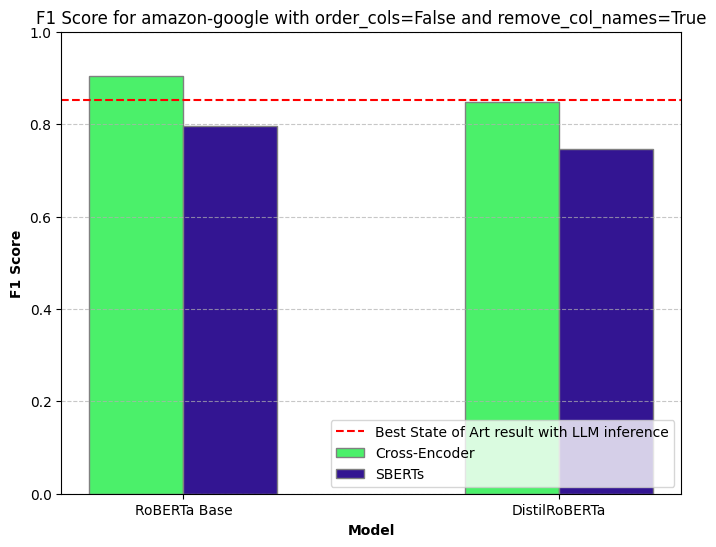

In [75]:
data_name = 'amazon-google'
order_cols = False
remove_col_names = True

f1_score_cross_roberta_base = results_dict_cross[data_name]['cross-encoder/stsb-roberta-base'][order_cols][remove_col_names]['f1']
f1_score_cross_distilbert = results_dict_cross[data_name]['cross-encoder/stsb-distilroberta-base'][order_cols][remove_col_names]['f1']

f1_score_bert_roberta_base = results_dict_bert[data_name]['roberta-base'][order_cols][remove_col_names]['f1']
f1_score_bert_distilbert = results_dict_bert[data_name]['distilroberta-base'][order_cols][remove_col_names]['f1']

index = ['RoBERTa Base', 'DistilRoBERTa']
bar_width = 0.25

plt.figure(figsize=(8, 6))

# Set position of bar on X axis
r1 = range(len(index))
r2 = [x + bar_width for x in r1]

# Make the plot
plt.bar(r1, [f1_score_cross_roberta_base, f1_score_cross_distilbert], color='#4BF06A', width=bar_width, edgecolor='grey', label='Cross-Encoder')
plt.bar(r2, [f1_score_bert_roberta_base, f1_score_bert_distilbert], color='#331592', width=bar_width, edgecolor='grey', label='SBERTs')

# Add horizontal line for best state of art result
plt.axhline(y=0.8521, color='red', linestyle='--', label='Best State of Art result with LLM inference')

# Add labels
plt.xlabel('Model', fontweight='bold')
plt.ylabel('F1 Score', fontweight='bold')
plt.title(f'F1 Score for {data_name} with order_cols={order_cols} and remove_col_names={remove_col_names}')
plt.xticks([r + bar_width/2 for r in range(len(index))], index)
plt.legend(loc='lower right')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

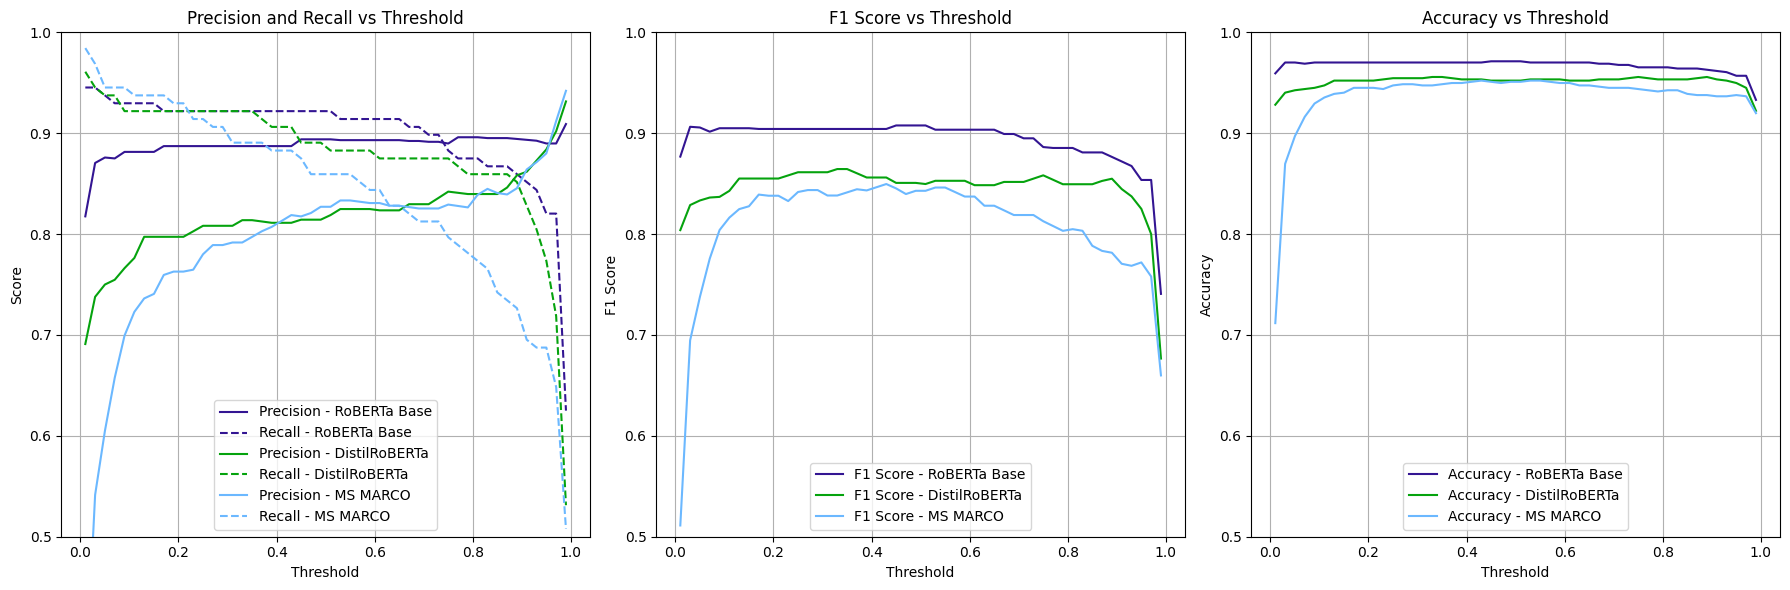

In [97]:
# Plot some tresholds

data_name = 'amazon-google'
order_cols = False
remove_col_names = True

f1_score_cross_roberta_base = []
recall_cross_roberta_base = []
precision_cross_roberta_base = []
accuracy_cross_roberta_base = []
f1_score_cross_distilbert = []
recall_cross_distilbert = []
precision_cross_distilbert = []
accuracy_cross_distilbert = []
f1_score_ms_marco = []
recall_ms_marco = []
precision_ms_marco = []
accuracy_ms_marco = []

thresholds = np.linspace(0.01, 0.99, 50)

colors = ['#331592', '#05A30E', '#6BB8FF']

# Load data
table_a_serialized, table_b_serialized, X_train_ids, y_train, X_valid_ids, y_valid, X_test_ids, y_test = load_data(os.path.join(import_data.DATA_FOLDER, data_name))

for threshold in thresholds:
    logits_roberta_base = results_dict_cross[data_name]['cross-encoder/stsb-roberta-base'][order_cols][remove_col_names]['logits']['pred'].values
    logits_distilbert = results_dict_cross[data_name]['cross-encoder/stsb-distilroberta-base'][order_cols][remove_col_names]['logits']['pred'].values
    logits_ms_marco = results_dict_cross[data_name]['cross-encoder/ms-marco-MiniLM-L-12-v2'][order_cols][remove_col_names]['logits']['pred'].values

    f1_score_cross_roberta_base.append(f1_score(y_test, logits_roberta_base > threshold))
    recall_cross_roberta_base.append(recall_score(y_test, logits_roberta_base > threshold))
    precision_cross_roberta_base.append(precision_score(y_test, logits_roberta_base > threshold, zero_division=1))
    accuracy_cross_roberta_base.append(accuracy_score(y_test, logits_roberta_base > threshold))
    
    f1_score_cross_distilbert.append(f1_score(y_test, logits_distilbert > threshold))
    recall_cross_distilbert.append(recall_score(y_test, logits_distilbert > threshold))
    precision_cross_distilbert.append(precision_score(y_test, logits_distilbert > threshold, zero_division=1))
    accuracy_cross_distilbert.append(accuracy_score(y_test, logits_distilbert > threshold))
    
    f1_score_ms_marco.append(f1_score(y_test, logits_ms_marco > threshold))
    recall_ms_marco.append(recall_score(y_test, logits_ms_marco > threshold))
    precision_ms_marco.append(precision_score(y_test, logits_ms_marco > threshold, zero_division=1))
    accuracy_ms_marco.append(accuracy_score(y_test, logits_ms_marco > threshold))

plt.figure(figsize=(3*6,6))

# Plot Precision and Recall
plt.subplot(1, 3, 1)
plt.plot(thresholds, precision_cross_roberta_base, label='Precision - RoBERTa Base', color=colors[0])
plt.plot(thresholds, recall_cross_roberta_base, label='Recall - RoBERTa Base', linestyle='--', color=colors[0])
plt.plot(thresholds, precision_cross_distilbert, label='Precision - DistilRoBERTa', color=colors[1])
plt.plot(thresholds, recall_cross_distilbert, label='Recall - DistilRoBERTa', linestyle='--', color=colors[1])
plt.plot(thresholds, precision_ms_marco, label='Precision - MS MARCO', color=colors[2])
plt.plot(thresholds, recall_ms_marco, label='Recall - MS MARCO', linestyle='--', color=colors[2])
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend(loc='lower center')
plt.ylim(0.5,1)
plt.grid(True)

# Plot F1 Score
plt.subplot(1, 3, 2)
plt.plot(thresholds, f1_score_cross_roberta_base, label='F1 Score - RoBERTa Base', color=colors[0])
plt.plot(thresholds, f1_score_cross_distilbert, label='F1 Score - DistilRoBERTa', color=colors[1])
plt.plot(thresholds, f1_score_ms_marco, label='F1 Score - MS MARCO', color=colors[2])
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend(loc='lower center')
plt.ylim(0.5,1)
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 3, 3)
plt.plot(thresholds, accuracy_cross_roberta_base, label='Accuracy - RoBERTa Base', color=colors[0])
plt.plot(thresholds, accuracy_cross_distilbert, label='Accuracy - DistilRoBERTa', color=colors[1])
plt.plot(thresholds, accuracy_ms_marco, label='Accuracy - MS MARCO', color=colors[2])
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Threshold')
plt.legend(loc='lower center')
plt.ylim(0.5,1)
plt.grid(True)

plt.tight_layout()
plt.show()


In [66]:
def get_best_f1_score(results_dict):
    best_f1_scores = {}
    for data_name, models in results_dict.items():
        best_f1_scores[data_name] = {}
        for model_name, configs in models.items():
            best_f1 = 0
            for order_cols, remove_cols_dict in configs.items():
                for remove_col_names, metrics in remove_cols_dict.items():
                    if 'f1' in metrics and metrics['f1'] > best_f1:
                        best_f1 = metrics['f1']
            best_f1_scores[data_name][model_name] = best_f1
    return best_f1_scores

best_f1_scores_zshot = get_best_f1_score(results_dict_zshot)
best_f1_scores_cross = get_best_f1_score(results_dict_cross)
best_f1_scores_bert = get_best_f1_score(results_dict_bert)
best_f1_scores_blocking = get_best_f1_score(results_dict_blocking)

print("Best F1 scores for Zero-Shot models:")
for data_name, models in best_f1_scores_zshot.items():
    for model_name, f1_score in models.items():
        print(f"{data_name} - {model_name}: {f1_score}")

print("\nBest F1 scores for Cross-Encoder models:")
for data_name, models in best_f1_scores_cross.items():
    for model_name, f1_score in models.items():
        print(f"{data_name} - {model_name}: {f1_score}")

print("\nBest F1 scores for BERT models:")
for data_name, models in best_f1_scores_bert.items():
    for model_name, f1_score in models.items():
        print(f"{data_name} - {model_name}: {f1_score}")

print("\nBest F1 scores for Blocking models:")
for data_name, models in best_f1_scores_blocking.items():
    for model_name, f1_score in models.items():
        print(f"{data_name} - {model_name}: {f1_score}")

Best F1 scores for Zero-Shot models:
fodors-zagats - all-mpnet-base-v2: 0.5945945945945946
fodors-zagats - sentence-transformers/multi-qa-mpnet-base-dot-v1: 0.46808510638297873
amazon-google - all-mpnet-base-v2: 0.6523076923076923
amazon-google - sentence-transformers/multi-qa-mpnet-base-dot-v1: 0.5502645502645502
abt-buy - all-mpnet-base-v2: 0.43103448275862066
abt-buy - sentence-transformers/multi-qa-mpnet-base-dot-v1: 0.39106145251396646

Best F1 scores for Cross-Encoder models:
fodors-zagats - cross-encoder/stsb-roberta-base: 1.0
fodors-zagats - cross-encoder/stsb-distilroberta-base: 1.0
fodors-zagats - cross-encoder/ms-marco-MiniLM-L-12-v2: 1.0
amazon-google - cross-encoder/stsb-roberta-base: 0.9034749034749034
amazon-google - cross-encoder/stsb-distilroberta-base: 0.8484848484848485
amazon-google - cross-encoder/ms-marco-MiniLM-L-12-v2: 0.8487084870848709
abt-buy - cross-encoder/stsb-roberta-base: 0.9488372093023256
abt-buy - cross-encoder/stsb-distilroberta-base: 0.9302325581395

In [67]:
summary_data_frame = pd.DataFrame(columns=['method', 'data_name', 'model_name', 'Remove Col Names', 'Order Cols', 'Recall', 'F1 Score'])

for data_name, models in results_dict_zshot.items():
    for model_name, configs in models.items():
        for order_cols, remove_cols_dict in configs.items():
            for remove_col_names, metrics in remove_cols_dict.items():
                summary_data_frame = pd.concat([summary_data_frame, pd.DataFrame({
                    'method': ['Zero-Shot'],
                    'data_name': [data_name],
                    'model_name': [model_name],
                    'Remove Col Names': [remove_col_names],
                    'Order Cols': [order_cols],
                    'Recall': [metrics['recall']],
                    'F1 Score': [metrics['f1']]
                })], ignore_index=True)
                
for data_name, models in results_dict_cross.items():
    for model_name, configs in models.items():
        for order_cols, remove_cols_dict in configs.items():
            for remove_col_names, metrics in remove_cols_dict.items():
                summary_data_frame = pd.concat([summary_data_frame, pd.DataFrame({
                    'method': ['Cross-Encoder'],
                    'data_name': [data_name],
                    'model_name': [model_name],
                    'Remove Col Names': [remove_col_names],
                    'Order Cols': [order_cols],
                    'Recall': [metrics['recall']],
                    'F1 Score': [metrics['f1']]
                })], ignore_index=True)
                
for data_name, models in results_dict_bert.items():
    for model_name, configs in models.items():
        for order_cols, remove_cols_dict in configs.items():
            for remove_col_names, metrics in remove_cols_dict.items():
                summary_data_frame = pd.concat([summary_data_frame, pd.DataFrame({
                    'method': ['SBERTs'],
                    'data_name': [data_name],
                    'model_name': [model_name],
                    'Remove Col Names': [remove_col_names],
                    'Order Cols': [order_cols],
                    'Recall': [metrics['recall']],
                    'F1 Score': [metrics['f1']]
                })], ignore_index=True)
                
for data_name, models in results_dict_blocking.items():
    for model_name, configs in models.items():
        for order_cols, remove_cols_dict in configs.items():
            for remove_col_names, metrics in remove_cols_dict.items():
                for K, metrics in metrics.items():
                    summary_data_frame = pd.concat([summary_data_frame, pd.DataFrame({
                        'method': ['Blocking'],
                        'data_name': [data_name],
                        'model_name': [model_name],
                        'Remove Col Names': [remove_col_names],
                        'Order Cols': [order_cols],
                        'Recall': [metrics['recall']],
                        'F1 Score': [metrics['f1']]
                    })], ignore_index=True)
                    
summary_data_frame

/var/folders/76/ktnqnwjn3kz2zdhpgy_03fww0000gn/T/ipykernel_63671/1972092153.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_data_frame = pd.concat([summary_data_frame, pd.DataFrame({


,method,data_name,model_name,Remove Col Names,Order Cols,Recall,F1 Score
0,Zero-Shot,fodors-zagats,all-mpnet-base-v2,True,True,1.0,0.594595
1,Zero-Shot,fodors-zagats,all-mpnet-base-v2,False,True,1.0,0.360656
2,Zero-Shot,fodors-zagats,all-mpnet-base-v2,True,False,1.0,0.578947
3,Zero-Shot,fodors-zagats,all-mpnet-base-v2,False,False,1.0,0.343750
4,Zero-Shot,fodors-zagats,sentence-transformers/multi-qa-mpnet-base-dot-v1,True,True,1.0,0.458333
...,...,...,...,...,...,...,...
715,Blocking,abt-buy,multi-qa-mpnet-base-dot-v1,False,False,1.0,0.980487
716,Blocking,abt-buy,multi-qa-mpnet-base-dot-v1,False,False,1.0,0.978364
717,Blocking,abt-buy,multi-qa-mpnet-base-dot-v1,False,False,1.0,0.976201
718,Blocking,abt-buy,multi-qa-mpnet-base-dot-v1,False,False,1.0,0.974036
